# Classifying clothes in Fashion MNIST using TDA

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import gudhi as gd
import gudhi.representations
import extract_featurized_barcodes as ex
from fashion_mnist import mnist_reader

## Calculate filtrations and barcodes

First, we load the images and generate their inverse

In [2]:
X_train, y_train = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('fashion_mnist/data/fashion', kind='t10k')
Opp_train = 255 - X_train
Opp_test = 255 - X_test

Then, we calculate their cubical complexes. It takes 7 minutes.

In [3]:
cub_filtration = lambda image : gd.CubicalComplex(dimensions = [28,28], top_dimensional_cells=image)
calculate_pd = lambda image : cub_filtration(image).persistence()

train_pds = list(map(calculate_pd, X_train))
test_pds = list(map(calculate_pd, X_test))
train_pds_opp = list(map(calculate_pd, Opp_train))
test_pds_opp = list(map(calculate_pd, Opp_test))

We remove infinity bars and separate the dimensions of each barcode

In [4]:
infty_proj = lambda x : 256 if ~np.isfinite(x) else x

intervals_of_dim_0 = lambda pd : np.array([[x[1][0], infty_proj(x[1][1])]  for x in pd if x[0]==0])
train_pds_0 = list(map(intervals_of_dim_0, train_pds))
test_pds_0 = list(map(intervals_of_dim_0, test_pds))
train_pds_opp_0 = list(map(intervals_of_dim_0, train_pds_opp))
test_pds_opp_0 = list(map(intervals_of_dim_0, test_pds_opp))

intervals_of_dim_1 = lambda pd : np.array([[x[1][0], infty_proj(x[1][1])]  for x in pd if x[0]==1])
train_pds_1 = list(map(intervals_of_dim_1, train_pds))
test_pds_1 = list(map(intervals_of_dim_1, test_pds))
train_pds_opp_1 = list(map(intervals_of_dim_1, train_pds_opp))
test_pds_opp_1 = list(map(intervals_of_dim_1, test_pds_opp))

## Classification with the Betti Curve

We perform a classification task using the betti curve and Random Forest. We concatenate the four betti curves obtained from each image, and then feed the classifier with them. It takes 1 minutes.

In [5]:
res = 100
train_Btt_0 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_0]
train_Btt_1 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_1]
test_Btt_0 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_0]
test_Btt_1 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_1]
train_Btt_opp_0 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_opp_0]
train_Btt_opp_1 = [ex.GetBettiCurveFeature(pd, res) for pd in train_pds_opp_1]
test_Btt_opp_0 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_opp_0]
test_Btt_opp_1 = [ex.GetBettiCurveFeature(pd, res) for pd in test_pds_opp_1]
train_Btt = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(train_Btt_0, train_Btt_1, train_Btt_opp_0, train_Btt_opp_1)]
test_Btt = [np.concatenate([dgm0,dgm1,dgm2,dgm3]) for dgm0,dgm1,dgm2,dgm3 in zip(test_Btt_0, test_Btt_1, test_Btt_opp_0, test_Btt_opp_1)]

Example of how the curves look like after the concatenation.

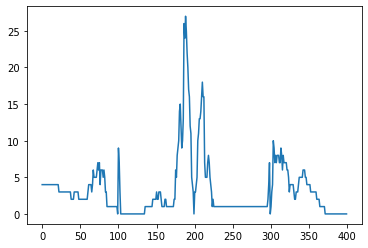

In [6]:
plt.plot(train_Btt[0])

We perform the classification task

In [7]:
classifier = RandomForestClassifier()
classifier = classifier.fit(train_Btt, y_train)  

In [8]:
print("Train accuracy = " + str(classifier.score(train_Btt, y_train)))
print("Test accuracy  = " + str(classifier.score(test_Btt, y_test))) 

Train accuracy = 1.0
Test accuracy  = 0.5796
